In [31]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from collections import OrderedDict
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
import matplotlib.cm as cm
import time
import scipy.sparse
import seaborn as sns
import lightgbm as lgb
import category_encoders as ce
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
import pickle

dosTPath = "../../../../../dosT/ffunes/"

%matplotlib inline

sns.set_theme()

# Función para calcular distancias entre datos predecidos y reales

In [2]:
geonames = pd.read_pickle(dosTPath + "geonames_parsed.pkl")

from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_distance(row):
    predicted_lat = row['predicted_lat']
    predicted_lon = row['predicted_lon']
    real_lat = row['real_lat']
    real_long = row['real_lon']
    
    return haversine_distance(predicted_lat, predicted_lon, real_lat, real_long)

def get_difference_distance(predicted_place, real_place):
    df_prediction = pd.DataFrame({
        'predicted_place': predicted_place,
        'real_place': real_place
    }, dtype=float)
        
    #df_prediction[['predicted_cities','predicted_countries']] = df_prediction.predicted_place.str.split(',', expand=True) 
    #df_prediction[['real_cities','real_countries']] = df_prediction.real_place.str.split(',', expand=True) 
    
    #del df_prediction['predicted_place']
    #del df_prediction['real_place']
    
    #df_prediction = pd.merge(
    #    left=df_prediction,
    #    right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
    #    how='left',
    #    left_on=['predicted_cities', 'predicted_countries'],
    #    right_on=['alternatenames', 'country'],
    #    validate='m:1'
    #)
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=places_with_coords,
        how='inner',
        left_on='predicted_place',
        right_on='unified_place',
        validate='m:1'
    ).rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'})
        
    df_prediction = pd.merge(
        left=df_prediction,
        right=places_with_coords,
        how='inner',
        left_on='real_place',
        right_on='unified_place',
        validate='m:1'
    ).rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'})    
    
    #df_prediction.rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'}, inplace=True)
    
    #del df_prediction['alternatenames']
    #del df_prediction['country']
    
    #df_prediction = pd.merge(
    #    left=df_prediction,
    #    right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
    #    how='left',
    #    left_on=['real_cities', 'real_countries'],
    #    right_on=['alternatenames', 'country'],
    #    validate='m:1'
    #)
    
    #del df_prediction['alternatenames']
    #del df_prediction['country']
    
    #df_prediction.rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'}, inplace=True)
    
    #print(df_prediction.head(5))
    
    #print("Total NaN: ", df_prediction.shape[0]-df_prediction.dropna(subset=['real_lat', 'real_lon', 'predicted_lat', 'predicted_lon']).shape[0])

    return df_prediction.apply(determine_distance, axis=1)

def accuracy_161km(real_place, pred_place):
    dif_distance = get_difference_distance(pred_place, real_place)
    
    total_positives = 0
    
    for val in dif_distance:
        if val <= 161:
            total_positives += 1
    
    return total_positives / len(dif_distance)

Nested cross validation

In [3]:
def nested_cross_validation(estimator, params, X, y, inner_cv=3, outer_cv=5):
    inner_cv = StratifiedKFold(n_splits=inner_cv, shuffle=True, random_state=44540570)
    outer_cv = StratifiedKFold(n_splits=outer_cv, shuffle=True, random_state=45405450)
    
    clf = GridSearchCV(
        estimator=estimator,
        param_grid=params,
        cv=inner_cv,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo'],
        refit='roc_auc_ovo'
    )

    nested_score = cross_validate(
        clf,
        X=X,
        y=y,
        cv=outer_cv,
        n_jobs=-1,
        scoring={
            'accuracy': 'accuracy',
            'balanced_accuracy': 'balanced_accuracy',
            'roc_auc_ovo': 'roc_auc_ovo',
            'accuracy@161': make_scorer(accuracy_161km, greater_is_better=True)            
        }
    )

    nested_predict = cross_val_predict(
        clf,
        X=X,
        y=y,
        cv=outer_cv,
        n_jobs=-1,
        method='predict'
    )
    
    return nested_score, nested_predict

# Preparación de datos

In [4]:
users_with_content = pd.read_pickle(dosTPath + "total_users_content.pkl")
users_with_content.head(3)

,id,place_name,place_country,latitude,longitude,full_text
0,1059,guernica,argentina,-34.916199,-58.381111,[Noche de limpieza facial en Guernica Buenos ...
1,1081,boston,estados unidos,34.025379,-87.758362,"[i’m sure this won’t end in tears , quotable ..."
2,2677,lenox,estados unidos,42.356480,-73.284828,[ where can I find a list of the clever quotes...


In [5]:
users_with_content["unified_place"] = users_with_content["place_name"] + ',' + users_with_content["place_country"]

In [6]:
min_determined_place = users_with_content.loc[:, ["id", "unified_place"]].groupby("unified_place").\
                        count().reset_index()

min_determined_place = min_determined_place.loc[min_determined_place["id"] >= 1200, :]
min_determined_place.shape

(23, 2)

Creamos un dataframe con las ubicaciones de cada uno de las ciudades a predecir

In [7]:
min_determined_place[['city','country']] = min_determined_place.unified_place.str.split(',', expand=True) 
    
places_with_coords = pd.merge(
    left=min_determined_place,
    right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
    how='left',
    left_on=['city', 'country'],
    right_on=['alternatenames', 'country'],
    validate='m:1'
).loc[:, ["unified_place", "latitude", "longitude"]]

places_with_coords.head()

,unified_place,latitude,longitude
0,"asuncion,paraguay",-25.286461,-57.646999
1,"avellaneda,argentina",-29.117611,-59.658340
2,"caracas,venezuela",10.488010,-66.879189
3,"ciudad autónoma de buenos aires,argentina",-34.613152,-58.377232
4,"corrientes,argentina",-27.467840,-58.834400


In [8]:
users_train = pd.merge(
    left=users_with_content,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)

users_train.shape

(79642, 7)

In [9]:
users_train.dropna(subset=["full_text"], inplace=True)
users_train.reset_index(drop=True, inplace=True)
users_train.shape

(79642, 7)

In [10]:
users_train["full_text"] = users_train["full_text"].apply(lambda x: list(map(str, x)))

In [11]:
cities = users_train["unified_place"].values
class_names = sorted(users_train['unified_place'].unique())

# Prediccion usando one-hot encoding

In [12]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    min_df=20,
    max_df=0.4
    #vocabulary=total_users
)

vector_of_words = vectorizer.fit_transform(users_train["full_text"].apply(lambda x: ' '.join(x))).astype(np.uint8)
vector_of_words

<79642x68397 sparse matrix of type '<class 'numpy.uint8'>'
	with 20562419 stored elements in Compressed Sparse Row format>

In [13]:
estimator = MultinomialNB()

scores, predictions = nested_cross_validation(
    estimator,
    {'alpha': [1.0]},
    vector_of_words,
    cities,
)

scores

{'fit_time': array([10.32025266,  9.57668066, 10.12564206, 10.14282703,  9.56164265]),
 'score_time': array([1.18786073, 1.23633814, 1.04799747, 1.21830964, 1.34059763]),
 'test_accuracy': array([0.48257894, 0.4888568 , 0.48625063, 0.48518332, 0.48938975]),
 'test_balanced_accuracy': array([0.37667196, 0.37757747, 0.37774314, 0.36959809, 0.37557083]),
 'test_roc_auc_ovo': array([0.78366197, 0.78293207, 0.78411943, 0.77791416, 0.78389603]),
 'test_accuracy@161': array([0.58057631, 0.58610082, 0.58048719, 0.58337519, 0.59229031])}

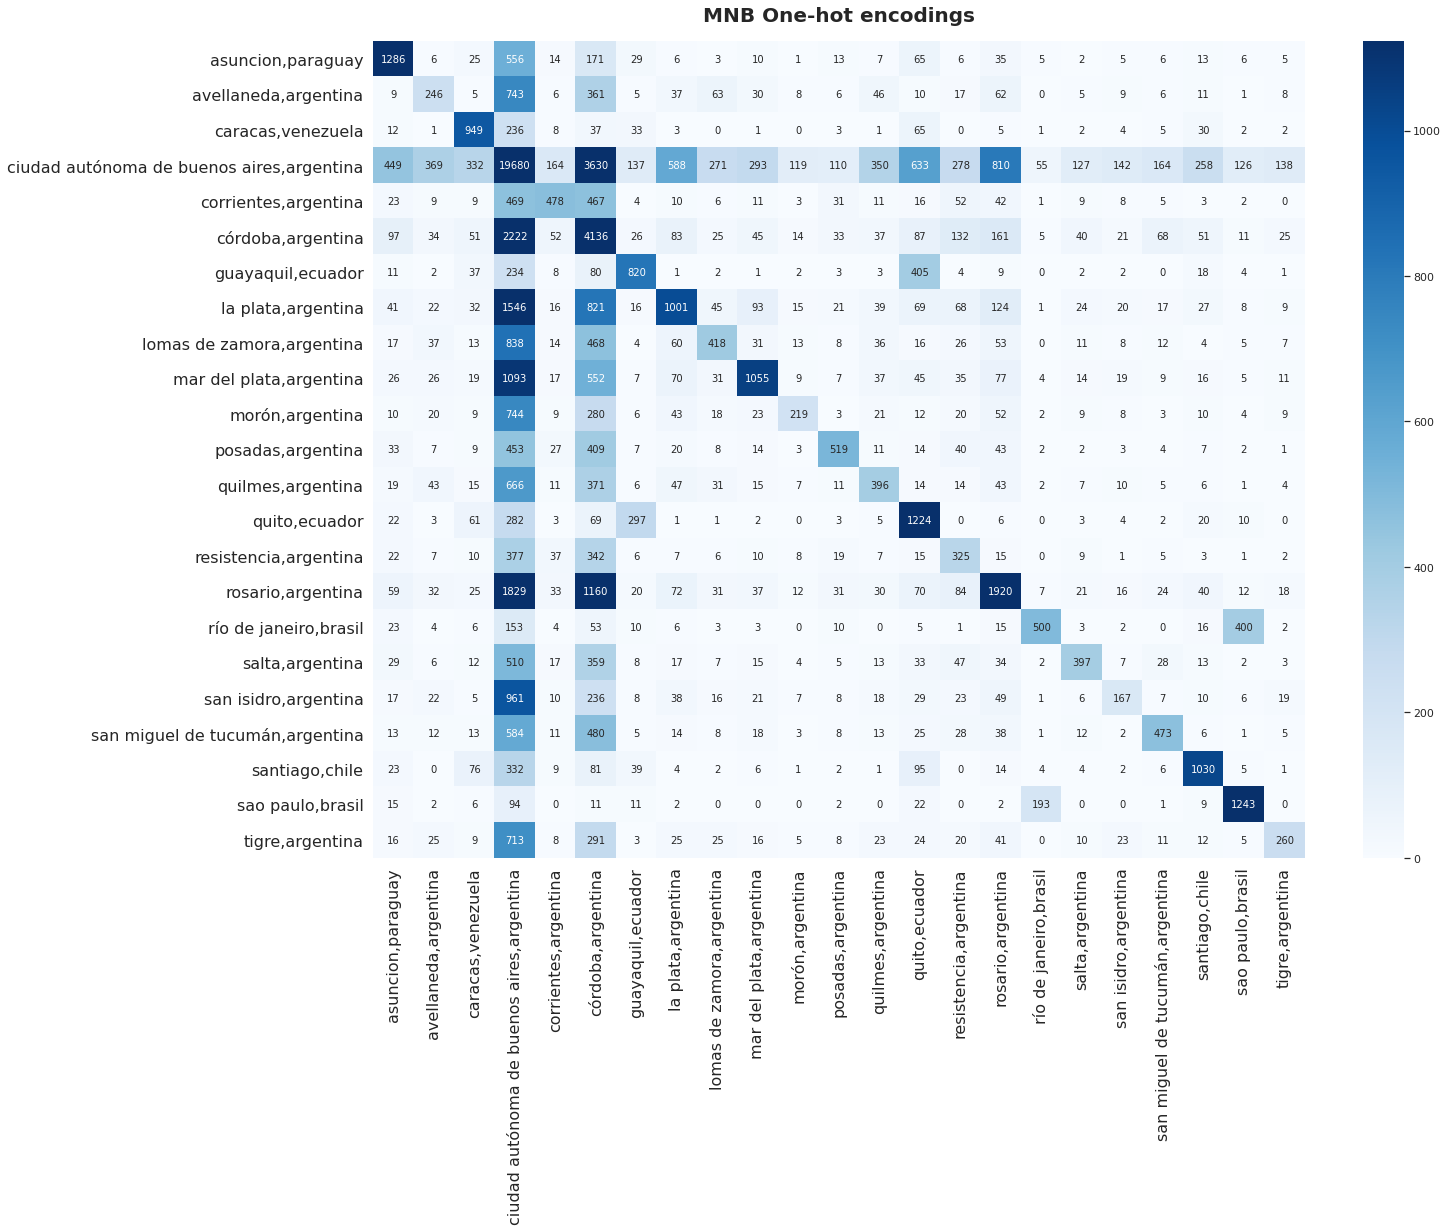

In [14]:
f, ax = plt.subplots(nrows=1, figsize=(25, 20))
i = 0
f.tight_layout(pad=30.0)

cm = confusion_matrix(cities, predictions, labels=class_names)

sns.heatmap(
    cm,
    annot=True,
    #linewidths=.5,
    fmt='d',
    robust=True,
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax
)
    
ax.set_title("MNB One-hot encodings", fontsize=20, fontweight='bold', pad=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

# Predicciones TF-IDF

In [15]:
vectorizer = TfidfVectorizer(
    strip_accents="ascii",
    lowercase=True,
    min_df=20,
    max_df=0.4
    #vocabulary=total_users
)

vector_of_words = vectorizer.fit_transform(users_train["full_text"].apply(lambda x: ' '.join(x))).astype(np.uint8)
vector_of_words

KeyboardInterrupt: 

In [ ]:
estimator = MultinomialNB()

scores, predictions = nested_cross_validation(
    estimator,
    {'alpha': [1.0]},
    vector_of_words,
    cities,
)

scores

In [ ]:
f, ax = plt.subplots(nrows=1, figsize=(25, 20))
i = 0
f.tight_layout(pad=30.0)

cm = confusion_matrix(cities, predictions, labels=class_names)

sns.heatmap(
    cm,
    annot=True,
    #linewidths=.5,
    fmt='d',
    robust=True,
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax
)
    
ax.set_title("MNB Tf-idf encodings", fontsize=20, fontweight='bold', pad=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

# Keras NN

In [17]:
encoder = LabelBinarizer()

cities_enc = encoder.fit_transform(cities)

all_tweets = users_train["full_text"].apply(lambda x: ' '.join(x)).values

Recordando que la media de largo de cada tweet es aproximadamente 71 caracteres, calculemos la media de tweets por usuario para ver cuantos features tener en cuenta

In [18]:
users_train["full_text"].str.len().median()

10.0

In [19]:
def accuracy_161km_k(y_real, y_pred):
    real_place = encoder.inverse_transform(y_real.numpy())
    pred_place = encoder.inverse_transform(y_pred.numpy())

    return accuracy_161km(real_place, pred_place)

In [20]:
max_features = 256
embedding_dim = 64
sequence_length = 128
number_classes = len(class_names)

In [21]:
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(all_tweets)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1113367 unique tokens.


In [22]:
X = tokenizer.texts_to_sequences(all_tweets)
X = pad_sequences(X, maxlen=sequence_length, truncating='post', padding='pre')
print('Shape of data tensor:', X.shape)

Shape of data tensor: (79642, 128)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    cities_enc,
    test_size=0.2,
    random_state=42,
    shuffle= True
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42,
    shuffle= True
)

print("Shapes are: X_train: %s X_val: %s X_test: %s" % (X_train.shape, X_valid.shape, X_test.shape))

Shapes are: X_train: (47784, 128) X_val: (15929, 128) X_test: (15929, 128)


In [29]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=X.shape[1], mask_zero=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(number_classes, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 64)           16384     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 128, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 23)                2323      
Total params: 84,707
Trainable params: 84,707
Non-trainable params: 0
_________________________________________________________________


In [30]:
epochs = 30
batch_size = 64

# Considerar pasar un class_weight dadas nuestras muestras no balanceadas
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

Epoch 1/30
747/747 [==============================] - 118s 124ms/step - loss: 2.5541 - accuracy: 0.3677 - val_loss: 2.3778 - val_accuracy: 0.3914
Epoch 2/30
180/747 [======>.......................] - ETA: 1:04 - loss: 2.3572 - accuracy: 0.3946

KeyboardInterrupt: 

In [52]:
history.history

{'loss': [2.405755043029785,
  2.228692054748535,
  2.108675003051758,
  2.0204195976257324,
  1.9715827703475952,
  1.9330503940582275,
  1.9167704582214355,
  1.8981220722198486,
  1.8753398656845093,
  1.8597877025604248,
  1.8477447032928467,
  1.833580493927002,
  1.8208564519882202,
  1.8075511455535889,
  1.7968252897262573],
 'accuracy': [0.39498576521873474,
  0.4313996434211731,
  0.4495437741279602,
  0.4647371470928192,
  0.47256404161453247,
  0.4804536998271942,
  0.4827347993850708,
  0.48581114411354065,
  0.490477979183197,
  0.49242424964904785,
  0.4939101040363312,
  0.49794909358024597,
  0.5001674294471741,
  0.5010672807693481,
  0.5046458840370178],
 'auc': [0.787382960319519,
  0.8229871392250061,
  0.8498547077178955,
  0.8653820753097534,
  0.8735442161560059,
  0.8795604109764099,
  0.8820114135742188,
  0.8854354023933411,
  0.8888171911239624,
  0.8913857340812683,
  0.8932203650474548,
  0.8954117298126221,
  0.8974058628082275,
  0.8992753624916077,
  0.

In [53]:
accr = model.evaluate(X_test, y_test)

498/498 [==============================] - 729s 1s/step - loss: 1.9173 - accuracy: 0.4864 - auc: 0.8802 - accuracy_161km_k: 0.6208


In [34]:
def jaccard_similar(a, b):
    setA = set(a)
    setB = set(b)
    
    return float(len(setA.intersection(setB)) / len(setA.union(setB)))

In [65]:
words = set()

for every_tweet in users_train["full_text"].values:
    for tweet in every_tweet:
        print("----------------------------")
        print("Original tweet: ", tweet)
        parsedTweet = ""
        
        for word in tweet.split():
            gotSimil = False

            if word in words:
                parsedTweet += word + " "
                continue

            for seenWord in words:
                jacc = jaccard_similar(seenWord, word)

                if jacc >= 0.90:
                    print("Very similar: [", word, "-", seenWord, "] With jacc:", jacc)
                    gotSimil = True
                    parsedTweet += seenWord + " "
                    continue
                
            if not gotSimil:
                parsedTweet += word + " "
                words.add(word)
                
        print("Parsed tweet: ", parsedTweet)
        print("----------------------------")

#users_train["full_text"].values[9]

----------------------------
Original tweet:  “Cuidar el oro y mandarles caballos de Troya a nuestros competidores” esa podría ser una estrategia para aumentar la rentabilidad de nuestro negocio Aunque tuviéramos que estimarlo seguro podemos graficar a… 
Very similar: [ nuestro - nuestros ] With jacc: 1.0
Parsed tweet:  “Cuidar el oro y mandarles caballos de Troya a nuestros competidores” esa podría ser una estrategia para aumentar la rentabilidad de nuestros negocio Aunque tuviéramos que estimarlo seguro podemos graficar a… 
----------------------------
----------------------------
Original tweet:  Lo que no sabía cuando empecé a publicar mis textos es que LinkedIn no estaba listo para mi pasión por las estadísticas Quería saber qué cosas hacen que un artículo se lea comente y comparta Entender eso… 
Very similar: [ se - es ] With jacc: 1.0
Parsed tweet:  Lo que no sabía cuando empecé a publicar mis textos es que LinkedIn no estaba listo para mi pasión por las estadísticas Quería sabe

Very similar: [ su - sus ] With jacc: 1.0
Parsed tweet:  “Lukas es una de las personas más inteligentes que conozco Con dos doctorados del MIT tuvo que dejar sus trabajo en la NSA (una de las agencias de inteligencia de EEUU) porque después de 2001 no aceptaban… 
----------------------------
----------------------------
Original tweet:  “¡Quiero publicar un ” parecen decir todos NO LO HAGAS O al menos no lo hagas sin saber todo lo que implica hacerlo bien Hoy mientras leía el capítulo cuarenta y pico para publicar en Spotify me… 
Very similar: [ al - la ] With jacc: 1.0
Parsed tweet:  “¡Quiero publicar un ” parecen decir todos NO LO HAGAS O la menos no lo hagas sin saber todo lo que implica hacerlo bien Hoy mientras leía el capítulo cuarenta y pico para publicar en Spotify me… 
----------------------------
----------------------------
Original tweet:  Cuando definí mi nuevo  esto de estudiar/escribir/compartir sobre  e  ya estaba convencido Claro hacía tiempo lo venía pensando discutie

Original tweet:  Corta y precisa sin más ni menos Descripción perfecta    
Parsed tweet:  Corta y precisa sin más ni menos Descripción perfecta 
----------------------------
----------------------------
Original tweet:  TRUE 
Parsed tweet:  TRUE 
----------------------------
----------------------------
Original tweet:  Ahhhhhhhhjajajajaja 
Parsed tweet:  Ahhhhhhhhjajajajaja 
----------------------------
----------------------------
Original tweet:  UNA FRANELA QUE DIGA 
Parsed tweet:  UNA FRANELA QUE DIGA 
----------------------------
----------------------------
Original tweet:  Gracialagerencia 
Parsed tweet:  Gracialagerencia 
----------------------------
----------------------------
Original tweet:  La mal nutrición embaraza ahora no te digo yo pue 
Parsed tweet:  La mal nutrición embaraza ahora no te digo yo pue 
----------------------------
----------------------------
Original tweet:   
Parsed tweet:  
----------------------------
----------------------------
Original tweet:  l

Parsed tweet:  AAAAJAJAJAJAJAJAJAJAJAJAJAJAJAJAJAJAJAJA TAL CUAL 
----------------------------
----------------------------
Original tweet:   Eso es peor que la Junta de Condominio venezolana es lo peor qué hay No es normal la situación/relación con los inquilinos y los administradores aquí Es un pandemónium
Very similar: [ peor - pero ] With jacc: 1.0
Very similar: [ peor - pero ] With jacc: 1.0
Very similar: [ los - solo ] With jacc: 1.0
Very similar: [ los - solo ] With jacc: 1.0
Very similar: [ administradores - demostrando ] With jacc: 0.9
Parsed tweet:  Eso es pero que la Junta de Condominio venezolana es lo pero qué hay No es normal la situación/relación con solo inquilinos y solo demostrando aquí Es un pandemónium 
----------------------------
----------------------------
Original tweet:     Quepecao
Parsed tweet:  Quepecao 
----------------------------
----------------------------
Original tweet:   Proud 
Parsed tweet:  Proud 
----------------------------
---------------------

Very similar: [ estás - está ] With jacc: 1.0
Parsed tweet:  Estoy a punto de cometer una osadía Me montaré en el subte un viernes a ahora pico CON UNA LECHOZA PICADA POR LA MITAD EN UNA BOLSITA DENTRO DEL MORRAL Tú me está hablando de adrenalina? 
----------------------------
----------------------------
Original tweet:  Mis tías aprendieron a usar el dedito para arriba cuando comentan "algo" o se ríen de un comentario   Yo:Tía Maduro es tremendo mmgvo  Tía:   Y en eso se la pasan
Very similar: [ se - es ] With jacc: 1.0
Very similar: [ eso - esos ] With jacc: 1.0
Very similar: [ se - es ] With jacc: 1.0
Parsed tweet:  Mis tías aprendieron a usar el dedito para arriba cuando comentan "algo" o es ríen de un comentario Yo:Tía Maduro es tremendo mmgvo Tía: Y en esos es la pasan 
----------------------------
----------------------------
Original tweet:  Ayer complete la racha de boludismo bloqueando la otra tarjeta de débito que me quedaba Solo cuento con 50 pesos
Very similar: [ bloquean

Very similar: [ le - el ] With jacc: 1.0
Very similar: [ regale - llegar ] With jacc: 1.0
Parsed tweet:  La guara con la ideología del che aprendida solo porque fue para Cuba de paseo no vino a trabajar y el llegar la arepa a otra chama que dijo que Guaidó era "re copado" 
----------------------------
----------------------------
Original tweet:  Podrán cortar la flor pero jamás detener la primavera 
Parsed tweet:  Podrán cortar la flor pero jamás detener la primavera 
----------------------------
----------------------------
Original tweet:  Ayer me dijo una yo fui a Cuba y él hambre de allá no es verdad La revolución en su momento funcionó Respire profundo y me fui Hoy le llevo una arepa y trataré de tener una conversación sencilla con ella
Very similar: [ revolución - "revolución" ] With jacc: 0.9090909090909091
Very similar: [ su - sus ] With jacc: 1.0
Very similar: [ le - el ] With jacc: 1.0
Very similar: [ ella - lea ] With jacc: 1.0
Parsed tweet:  Ayer me dijo una yo fui a Cuba 

Parsed tweet:  Llegando la trabajo (si más de una ahora después) me doy cuenta que la sorpresas de la baldosa suelta que pise era PINTURA BLANCA 
----------------------------
----------------------------
Original tweet:  Me quede dormida y me pase la parada 2 cuadras llaneras Caminando rápido de vuelta para tomar el otro colectivo (porque agarro 3) pise una baldosa suelta y llena de agüita sorpresa Vamos que vamos
Very similar: [ sorpresa - sorpresas ] With jacc: 1.0
Very similar: [ Vamos - Vaaaamos ] With jacc: 1.0
Parsed tweet:  Me quede dormida y me pase la parada 2 cuadras llaneras Caminando rápido de vuelta para tomar el otro colectivo (porque agarro 3) pise una baldosa suelta y llena de agüita sorpresas Vaaaamos que vamos 
----------------------------
----------------------------
Original tweet:  Home sick
Parsed tweet:  Home sick 
----------------------------
----------------------------
Original tweet:  UpDate: el regalo de Gregorio  Resulta que su mama humana es prof en una es

Parsed tweet:  El gusto siempre es nuestros 
----------------------------
----------------------------
Original tweet:  En el cole con  
Parsed tweet:  En el cole con 
----------------------------
----------------------------
Original tweet:      Ja
Parsed tweet:  Ja 
----------------------------
----------------------------
Original tweet:  Savoca Tras las huellas de El Padrino 
Parsed tweet:  Savoca Tras las huellas de El Padrino 
----------------------------
----------------------------
Original tweet:  Fui tras los pasos de El Padrino hasta Savoca a tomarme un caféal bar Vitelli 
Very similar: [ los - solo ] With jacc: 1.0
Very similar: [ pasos - paso ] With jacc: 1.0
Parsed tweet:  Fui tras solo paso de El Padrino hasta Savoca a tomarme un caféal bar Vitelli 
----------------------------
----------------------------
Original tweet:  Llegue a Catania de casualidad el día de la fiesta de Santa Agata 
Parsed tweet:  Llegue a Catania de casualidad el día de la fiesta de Santa Agata 
-

Very similar: [ plata - palta ] With jacc: 1.0
Very similar: [ le - el ] With jacc: 1.0
Parsed tweet:  Yo el pago en efectivo pero antes de darle la palta el pido el ticket 
----------------------------
----------------------------
Original tweet:   I've added 10£ to my account I've got the app on my iPhone 8 while trying to validate my account the app hangs in the upload passport photo process  is that a feature??
Very similar: [ app - pa ] With jacc: 1.0
Very similar: [ on - no ] With jacc: 1.0
Very similar: [ app - pa ] With jacc: 1.0
Very similar: [ in - ni ] With jacc: 1.0
Very similar: [ is - si ] With jacc: 1.0
Very similar: [ that - hat ] With jacc: 1.0
Parsed tweet:  I've added 10£ to my account I've got the pa no my iPhone 8 while trying to validate my account the pa hangs ni the upload passport photo process si hat a feature?? 
----------------------------
----------------------------
Original tweet:   Malditaaaaaaaa   churaaaa churu charu churaaa churu charu charu churaaaa 

KeyboardInterrupt: 